### this is used to calculate the information loss of the data after filterin
to check if the filering affect the information content

In [18]:
import numpy as np
import mne
import matplotlib.pyplot as plt
import math
from golomb_code import encode, decode
from scipy.stats import entropy
from scipy.spatial.distance import cosine
import torch
import torch.nn.functional as F

In [2]:
## loading the filtered data
file = '4b5c_nofilter.edf'
data1 = mne.io.read_raw_edf(file)
data1.info
## only the important four channels are loaded and the noisy ones are discarded

Extracting EDF parameters from /home/ifire/EEG/H-IoT-Golob-Rice-Compression-Automation/EEG data/4b5c_nofilter.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


Measurement date,"April 27, 2022 07:50:40 GMT"
Experimenter,Unknown
Participant,X
Digitized points,Not available
Good channels,6 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,125.00 Hz
Highpass,0.00 Hz
Lowpass,62.50 Hz


Setting up low-pass filter at 60 Hz

IIR filter parameters
---------------------
Butterworth lowpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 40 (effective, after forward-backward)
- Cutoff at 60.00 Hz: -6.02 dB

Using matplotlib as 2D backend.


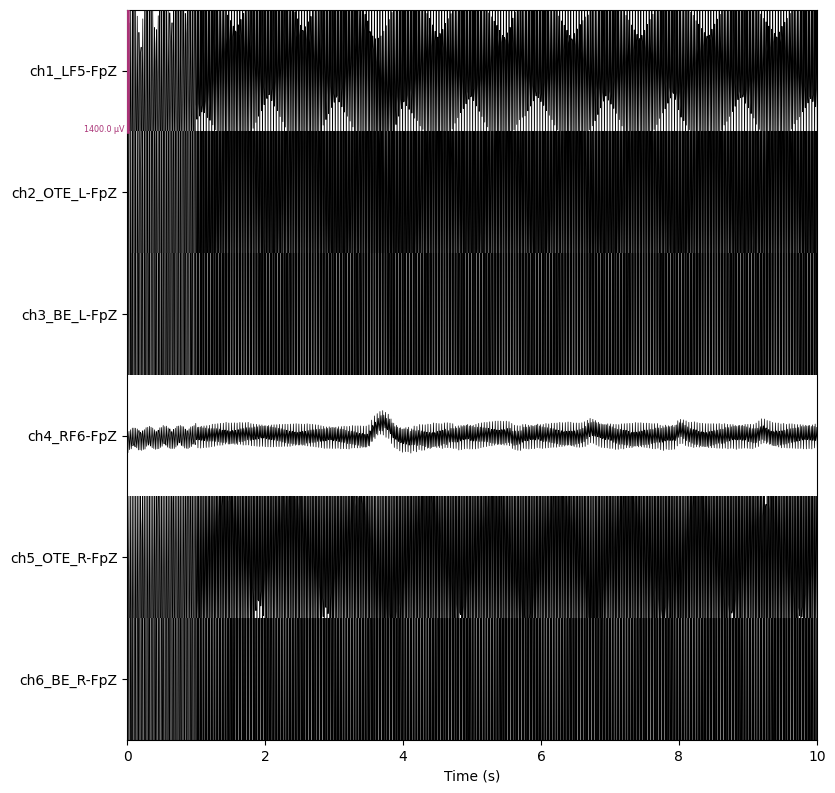

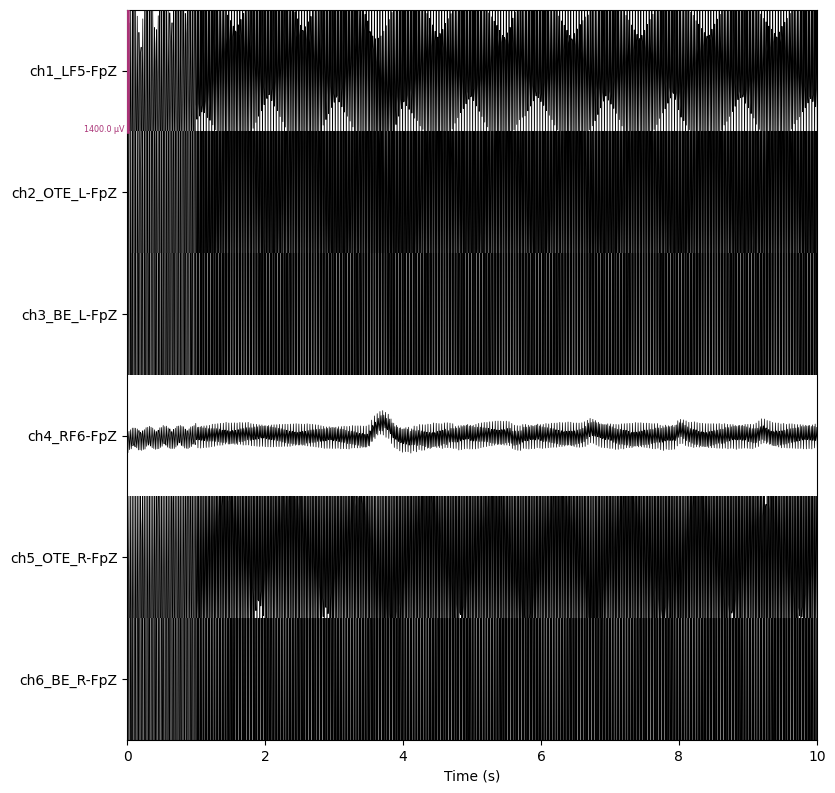

In [3]:
data1.plot( scalings='0.0007', clipping=0.5, remove_dc=True, lowpass =60, show_scrollbars=False, filtorder = 20, theme='auto')

In [4]:
data1.ch_names

['ch1_LF5-FpZ',
 'ch2_OTE_L-FpZ',
 'ch3_BE_L-FpZ',
 'ch4_RF6-FpZ',
 'ch5_OTE_R-FpZ',
 'ch6_BE_R-FpZ']

In [5]:
# Specify the channels you want to keep -- remove the behind ear bad channels
channels_to_keep = ['ch1_LF5-FpZ', 'ch2_OTE_L-FpZ', 'ch4_RF6-FpZ', 'ch5_OTE_R-FpZ']

# Use the pick_channels method to modify data1 in place, keeping only the specified channels
data1_selc = data1.pick_channels(channels_to_keep)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


In [6]:
data1_selc.info

Measurement date,"April 27, 2022 07:50:40 GMT"
Experimenter,Unknown
Participant,X
Digitized points,Not available
Good channels,4 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,125.00 Hz
Highpass,0.00 Hz
Lowpass,62.50 Hz


calcualting the kl between the raw and the filtered data 

In [7]:
''' we will use the scipy entropy function to calculate the kl los aka - relative entropy 
this will results in normalising the values if they dont sum up to 1'''

file = '4b5c_filtered.edf'
data2 = mne.io.read_raw_edf(file)
data2.info

Extracting EDF parameters from /home/ifire/EEG/H-IoT-Golob-Rice-Compression-Automation/EEG data/4b5c_filtered.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


Measurement date,"April 27, 2022 07:50:40 GMT"
Experimenter,Unknown
Participant,X
Digitized points,Not available
Good channels,4 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,125.00 Hz
Highpass,0.50 Hz
Lowpass,30.00 Hz


In [8]:
data2.ch_names

['ch1_LF5-FpZ', 'ch2_OTE_L-FpZ', 'ch4_RF6-FpZ', 'ch5_OTE_R-FpZ']

In [9]:
data2 = data2.get_data()
data1_selc = data1_selc.get_data()

In [14]:
data2.shape

(4, 152875)

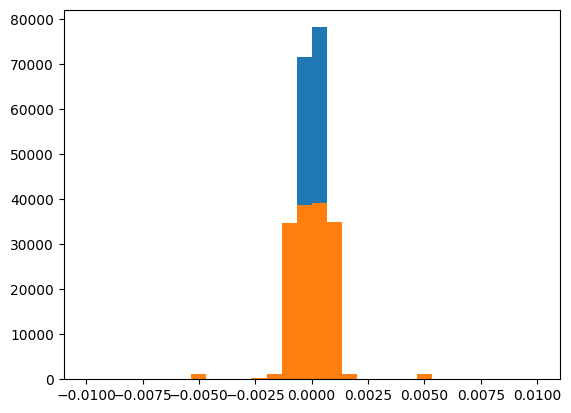

In [10]:
## channel 1 kl-div
plt.hist(data2[0], bins = 30, range = [-0.01, 0.01])
plt.hist(data1_selc[0], bins = 30, range = [-0.01, 0.01])
plt.show()

In [11]:
import scipy.stats as stats
import numpy as np

# Define two distributions
P = np.array([0.1, 0.4, 0.5])
Q = np.array([0.2, 0.3, 0.5])

# Calculate KL divergence from P to Q
kl_divergence = stats.entropy(P, Q)
print("KL Divergence from P to Q:", kl_divergence)


KL Divergence from P to Q: 0.04575811092471789


In [12]:
## claculate the cosine similarity 
print('Channel 1 cosine loss  {channel1}, Channel 2 cosine loss {channel2}, Channel 3 cosine loss {channel3}, Channel 4 cosine loss {channel4}'.format(channel1 = cosine(data1_selc[0], data2[0]), channel2 = cosine(data1_selc[1], data2[1]), channel3 = cosine(data1_selc[2], data2[2]),  channel4 = cosine(data1_selc[3], data2[3])))

Channel 1 cosine loss  0.6506078484886495, Channel 2 cosine loss 0.8513619175755744, Channel 3 cosine loss 0.4826134948447329, Channel 4 cosine loss 0.753581751571434


In [13]:
kl_divergence = stats.entropy(data2[0], data1_selc[0])
kl_divergence

inf

KL loss using the pytorch library 

channel 1

In [27]:
###tensor conversion 
data2_tensor = torch.from_numpy(data2)
data1_tensor = torch.from_numpy(data1_selc)

data2_tensor.shape, data1_tensor.shape

(torch.Size([4, 152875]), torch.Size([4, 152875]))

In [28]:
prob_data2_tensor_0 = F.softmax(data2_tensor, dim =1)[0]
prob_data1_tensor_0 = F.softmax(data1_tensor, dim =1)[0]

kl_loss_0 = F.kl_div(prob_data1_tensor_0, prob_data2_tensor_0, reduction = 'batchmean')
print('kl loss for the channel 1 eeg', kl_loss_0)

kl loss for the channel 1 eeg tensor(-7.8086e-05, dtype=torch.float64)


In [33]:
##using the suggested log normalising one probability vector
log_prob_0 = torch.log(prob_data1_tensor_0+ 1e-10)
kl_loss_0 = F.kl_div(log_prob_0, prob_data2_tensor_0, reduction = 'batchmean')
print('kl loss for the channel 1 eeg-', kl_loss_0) ## the loss is negative but the minimum the kl loss can be is 0 so we can assueme that the loss is small

kl loss for the channel 1 eeg- tensor(-9.6317e-11, dtype=torch.float64)


for 2nd channel 

In [34]:
prob_data2_tensor_1 = F.softmax(data2_tensor, dim =1)[1]
prob_data1_tensor_1 = F.softmax(data1_tensor, dim =1)[1]

kl_loss_0 = F.kl_div(prob_data2_tensor_1, prob_data1_tensor_1, reduction = 'batchmean')
print('kl loss for the channel 2 eeg', kl_loss_0)

##using the suggested log normalising one probability vector
log_prob_0 = torch.log(prob_data2_tensor_1+ 1e-10)
kl_loss_0 = F.kl_div(log_prob_0, prob_data1_tensor_1, reduction = 'batchmean')
print('kl loss for the channel 2 eeg-', kl_loss_0) ## the loss is negative but the minimum the kl loss can be is 0 so we can assueme that the loss is small

kl loss for the channel 2 eeg tensor(-7.8086e-05, dtype=torch.float64)
kl loss for the channel 2 eeg- tensor(-8.1444e-11, dtype=torch.float64)


for 3rd channel 

In [35]:
prob_data2_tensor_2 = F.softmax(data2_tensor, dim =1)[2]
prob_data1_tensor_2 = F.softmax(data1_tensor, dim =1)[2]

kl_loss_2 = F.kl_div(prob_data2_tensor_2, prob_data1_tensor_2, reduction = 'batchmean')
print('kl loss for the channel 3 eeg', kl_loss_2)

##using the suggested log normalising one probability vector
log_prob_0 = torch.log(prob_data2_tensor_2+ 1e-10)
kl_loss_2 = F.kl_div(log_prob_0, prob_data1_tensor_2, reduction = 'batchmean')
print('kl loss for the channel 3 eeg-', kl_loss_2) ## the loss is negative but the minimum the kl loss can be is 0 so we can assueme that the loss is small

kl loss for the channel 3 eeg tensor(-7.8086e-05, dtype=torch.float64)
kl loss for the channel 3 eeg- tensor(-9.7976e-11, dtype=torch.float64)


for channel 3

In [36]:
prob_data2_tensor_3 = F.softmax(data2_tensor, dim =1)[3]
prob_data1_tensor_3 = F.softmax(data1_tensor, dim =1)[3]

kl_loss_3 = F.kl_div(prob_data1_tensor_3, prob_data2_tensor_3, reduction = 'batchmean')
print('kl loss for the channel 4 eeg', kl_loss_3)

##using the suggested log normalising one probability vector
log_prob_0 = torch.log(prob_data2_tensor_3+ 1e-10)
kl_loss_3 = F.kl_div(log_prob_0, prob_data1_tensor_3, reduction = 'batchmean')
print('kl loss for the channel 4 eeg-', kl_loss_2) ## the loss is negative but the minimum the kl loss can be is 0 so we can assueme that the loss is small

kl loss for the channel 4 eeg tensor(-7.8086e-05, dtype=torch.float64)
kl loss for the channel 4 eeg- tensor(-9.7976e-11, dtype=torch.float64)
